<a href="https://colab.research.google.com/github/Chandana0127/Data_Mining_HW_3/blob/main/Data_Mining_HW_3_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NAME : CHANDANA VINAY KUMAR
## ASU ID : 1237227955

## Task 2, Machine Learning with Matrix Data for Recommender Systems

1. Recommender systems are a hot topic. Recommendation systems can be formulated as a task of matrix completion in machine learning. Recommender systems aim to predict the rating that a user will give for an item (e.g., a restaurant, a movie, a product).
2. Download the movie rating dataset from: https://www.kaggle.com/rounakbanik/the-movies-dataset. These files contain metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages. This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.
3. Building a small recommender system with the matrix data: “ratings small.csv”. You can use the recommender system library: Surprise (http://surpriselib.com), use other recommender system libraries, or implement from scratches.

In [1]:
# Install compatible versions
!pip install --upgrade --force-reinstall "numpy<2.0" scikit-surprise -q

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

from surprise import Dataset, Reader
from surprise import SVD
from surprise import KNNBasic, KNNWithMeans
from surprise.model_selection import cross_validate
from surprise import accuracy

print("Setup complete!")
print(f"NumPy version: {np.__version__}")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
Setup complete!
NumPy version: 1.26.4


#### a) Read data from “ratings small.csv” with line format: 'userID movieID rating timestamp'.

In [2]:
# ============================================================================
# BLOCK 2: Data Loading and Exploration (Question a)
# ============================================================================

# Load the ratings_small.csv file
# Format: userID, movieID, rating, timestamp
data_path = 'ratings_small.csv'

# Read the CSV file
df = pd.read_csv(data_path)

print("Dataset Information:")
print("=" * 80)
print(f"Total number of ratings: {len(df)}")
print(f"Number of unique users: {df['userId'].nunique()}")
print(f"Number of unique movies: {df['movieId'].nunique()}")
print(f"Rating scale: {df['rating'].min()} to {df['rating'].max()}")
print(f"Average rating: {df['rating'].mean():.2f}")
print("\nFirst few rows:")
print(df.head(10))

# Data statistics
print("\n" + "=" * 80)
print("Rating Distribution:")
print(df['rating'].value_counts().sort_index())

# Prepare data for Surprise library
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

print("\nData loaded and prepared for Surprise library.")

Dataset Information:
Total number of ratings: 100004
Number of unique users: 671
Number of unique movies: 9066
Rating scale: 0.5 to 5.0
Average rating: 3.54

First few rows:
   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205
5       1     1263     2.0  1260759151
6       1     1287     2.0  1260759187
7       1     1293     2.0  1260759148
8       1     1339     3.5  1260759125
9       1     1343     2.0  1260759131

Rating Distribution:
rating
0.5     1101
1.0     3326
1.5     1687
2.0     7271
2.5     4449
3.0    20064
3.5    10538
4.0    28750
4.5     7723
5.0    15095
Name: count, dtype: int64

Data loaded and prepared for Surprise library.


#### b) MAE and RMSE are two famous metrics for evaluating the performances of a
recommender system. The definition of MAE can be found via: https://en.wikipedia.org/wiki/Mean_absolute_error. The definition of RMSE can be found via: https://en.wikipedia.org/wiki/Root-mean-square_deviation.


#### c) Compute the average MAE and RMSE of the Probabilistic Matrix Factorization (PMF), User based Collaborative Filtering, Item based Collaborative Filtering, under the 5-folds cross-validation (10 points)

In [3]:
# ============================================================================
# BLOCK 3: Implement Three Algorithms with 5-Fold Cross-Validation (Question b, c)
# ============================================================================

# Define the three algorithms

# 1. Probabilistic Matrix Factorization (PMF) - using SVD
print("=" * 80)
print("1. Probabilistic Matrix Factorization (PMF using SVD)")
print("=" * 80)

pmf_algo = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)
pmf_results = cross_validate(pmf_algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print("\nPMF Results:")
print(f"  Average RMSE: {pmf_results['test_rmse'].mean():.4f} (+/- {pmf_results['test_rmse'].std():.4f})")
print(f"  Average MAE:  {pmf_results['test_mae'].mean():.4f} (+/- {pmf_results['test_mae'].std():.4f})")

# 2. User-based Collaborative Filtering
print("\n" + "=" * 80)
print("2. User-based Collaborative Filtering")
print("=" * 80)

user_based_options = {
    'name': 'cosine',
    'user_based': True
}
user_based_algo = KNNWithMeans(k=40, sim_options=user_based_options)
user_results = cross_validate(user_based_algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print("\nUser-based CF Results:")
print(f"  Average RMSE: {user_results['test_rmse'].mean():.4f} (+/- {user_results['test_rmse'].std():.4f})")
print(f"  Average MAE:  {user_results['test_mae'].mean():.4f} (+/- {user_results['test_mae'].std():.4f})")

# 3. Item-based Collaborative Filtering
print("\n" + "=" * 80)
print("3. Item-based Collaborative Filtering")
print("=" * 80)

item_based_options = {
    'name': 'cosine',
    'user_based': False
}
item_based_algo = KNNWithMeans(k=40, sim_options=item_based_options)
item_results = cross_validate(item_based_algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print("\nItem-based CF Results:")
print(f"  Average RMSE: {item_results['test_rmse'].mean():.4f} (+/- {item_results['test_rmse'].std():.4f})")
print(f"  Average MAE:  {item_results['test_mae'].mean():.4f} (+/- {item_results['test_mae'].std():.4f})")

# Store results for comparison
results_dict = {
    'PMF': {
        'RMSE': pmf_results['test_rmse'].mean(),
        'MAE': pmf_results['test_mae'].mean(),
        'RMSE_std': pmf_results['test_rmse'].std(),
        'MAE_std': pmf_results['test_mae'].std()
    },
    'User-based CF': {
        'RMSE': user_results['test_rmse'].mean(),
        'MAE': user_results['test_mae'].mean(),
        'RMSE_std': user_results['test_rmse'].std(),
        'MAE_std': user_results['test_mae'].std()
    },
    'Item-based CF': {
        'RMSE': item_results['test_rmse'].mean(),
        'MAE': item_results['test_mae'].mean(),
        'RMSE_std': item_results['test_rmse'].std(),
        'MAE_std': item_results['test_mae'].std()
    }
}

print("\n" + "=" * 80)
print("All three algorithms completed successfully!")
print("=" * 80)

1. Probabilistic Matrix Factorization (PMF using SVD)
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9031  0.8926  0.8933  0.8996  0.8931  0.8963  0.0042  
MAE (testset)     0.6955  0.6876  0.6880  0.6914  0.6876  0.6900  0.0031  
Fit time          1.49    1.72    1.33    1.34    1.33    1.44    0.15    
Test time         0.18    0.10    0.11    0.10    0.11    0.12    0.03    

PMF Results:
  Average RMSE: 0.8963 (+/- 0.0042)
  Average MAE:  0.6900 (+/- 0.0031)

2. User-based Collaborative Filtering
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating R

#### d) Compare the average (mean) performances of User-based collaborative filtering, item-based collaborative filtering, PMF with respect to RMSE and MAE. Which ML model is the best in the movie rating data? (10 points)

* Best model by RMSE: PMF (RMSE = 0.8963)
* Best model by MAE:  PMF (MAE = 0.6900)


COMPARISON OF THREE ALGORITHMS

Performance Metrics:
               RMSE (Mean)  RMSE (Std)  MAE (Mean)  MAE (Std)
PMF               0.896321    0.004243    0.690015   0.003083
User-based CF     0.924375    0.008577    0.708861   0.006362
Item-based CF     0.926294    0.003994    0.709001   0.004131

CONCLUSION:
Best model by RMSE: PMF (RMSE = 0.8963)
Best model by MAE:  PMF (MAE = 0.6900)


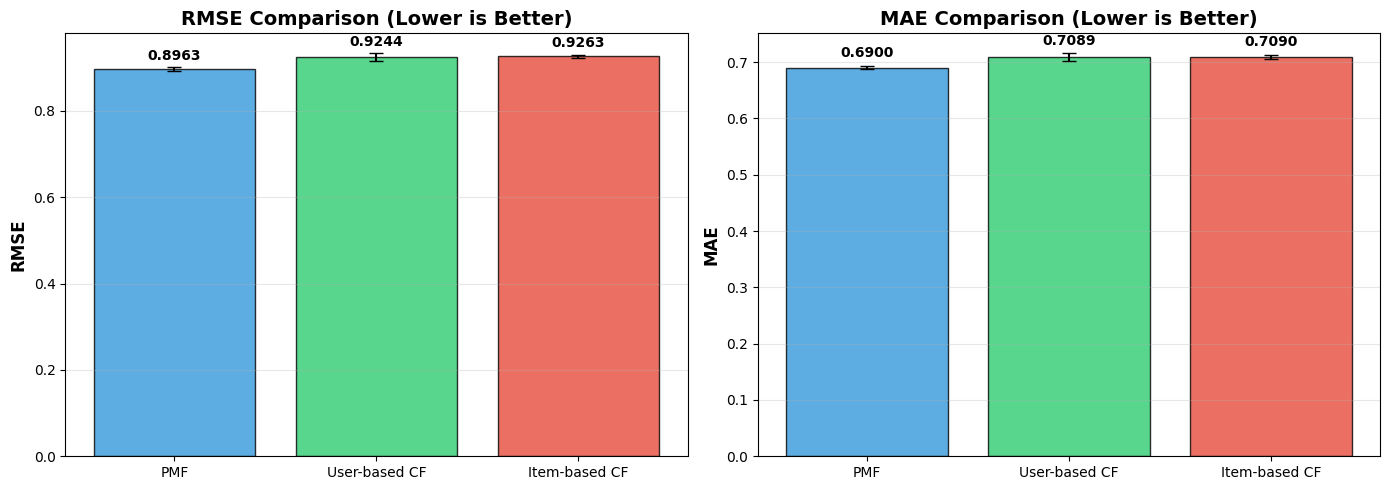


Visualization saved as 'algorithm_comparison.png'


In [4]:
# ============================================================================
# BLOCK 4: Compare the Three Algorithms (Question d)
# ============================================================================

print("\n" + "=" * 80)
print("COMPARISON OF THREE ALGORITHMS")
print("=" * 80)

# Create comparison dataframe
comparison_df = pd.DataFrame(results_dict).T
comparison_df = comparison_df[['RMSE', 'RMSE_std', 'MAE', 'MAE_std']]
comparison_df.columns = ['RMSE (Mean)', 'RMSE (Std)', 'MAE (Mean)', 'MAE (Std)']

print("\nPerformance Metrics:")
print(comparison_df.to_string())

# Determine the best model
best_rmse = comparison_df['RMSE (Mean)'].idxmin()
best_mae = comparison_df['MAE (Mean)'].idxmin()

print("\n" + "=" * 80)
print("CONCLUSION:")
print("=" * 80)
print(f"Best model by RMSE: {best_rmse} (RMSE = {comparison_df.loc[best_rmse, 'RMSE (Mean)']:.4f})")
print(f"Best model by MAE:  {best_mae} (MAE = {comparison_df.loc[best_mae, 'MAE (Mean)']:.4f})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
models = list(results_dict.keys())
rmse_values = [results_dict[m]['RMSE'] for m in models]
rmse_stds = [results_dict[m]['RMSE_std'] for m in models]

axes[0].bar(models, rmse_values, yerr=rmse_stds, capsize=5,
            color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('RMSE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (v, s) in enumerate(zip(rmse_values, rmse_stds)):
    axes[0].text(i, v + s + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

# MAE comparison
mae_values = [results_dict[m]['MAE'] for m in models]
mae_stds = [results_dict[m]['MAE_std'] for m in models]

axes[1].bar(models, mae_values, yerr=mae_stds, capsize=5,
            color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.8, edgecolor='black')
axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('MAE Comparison (Lower is Better)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for i, (v, s) in enumerate(zip(mae_values, mae_stds)):
    axes[1].text(i, v + s + 0.01, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('algorithm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'algorithm_comparison.png'")

#### e) Examine how the cosine, MSD (Mean Squared Difference), and Pearson similarities impact the performances of User based Collaborative Filtering and Item based Collaborative Filtering. Plot your results. Is the impact of the three metrics on User based Collaborative Filtering consistent with the impact of the three metrics on Item based Collaborative Filtering? (10 points)

* Yes the impact of the three metrics on User based Collaborative Filtering is consistent with the impact of the three metrics on Item based Collaborative Filtering.

* Both methods perform best with msd similarity.


EXAMINING IMPACT OF SIMILARITY METRICS

User-based Collaborative Filtering:
--------------------------------------------------------------------------------

Testing with COSINE similarity...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
  RMSE: 0.9218
  MAE:  0.7061

Testing with MSD similarity...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


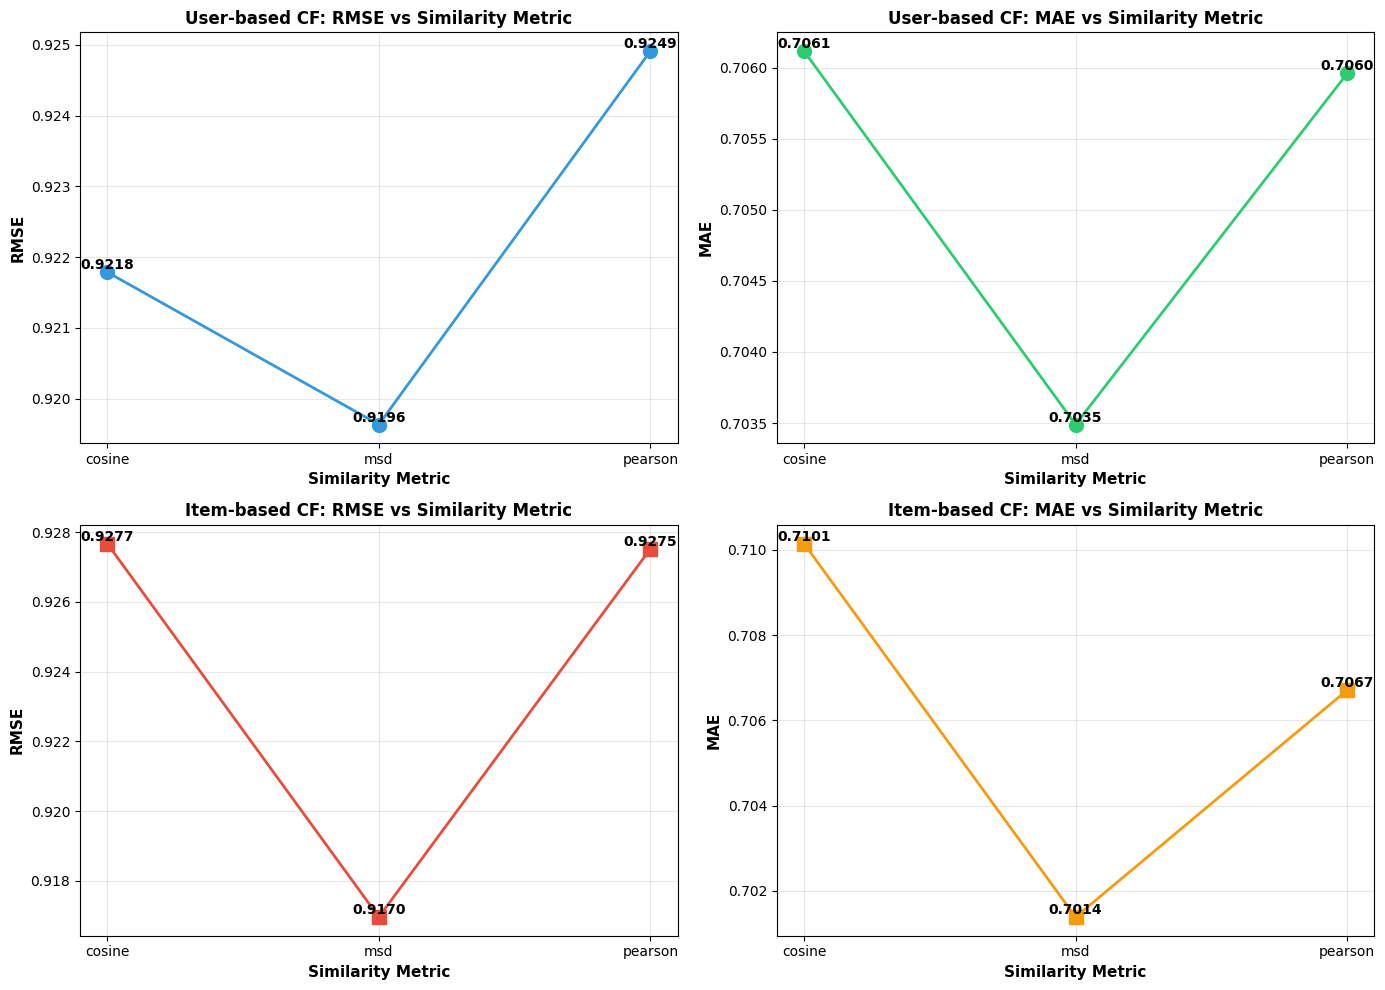


ANALYSIS:

Best similarity metric for User-based CF:
  RMSE: msd (0.9196)
  MAE:  msd (0.7035)

Best similarity metric for Item-based CF:
  RMSE: msd (0.9170)
  MAE:  msd (0.7014)

Is the impact consistent? True
Both methods perform best with msd similarity.

Visualization saved as 'similarity_metrics_impact.png'


In [5]:
# ============================================================================
# BLOCK 5: Impact of Similarity Metrics (Question e)
# ============================================================================

print("\n" + "=" * 80)
print("EXAMINING IMPACT OF SIMILARITY METRICS")
print("=" * 80)

# Define similarity metrics to test
similarity_metrics = ['cosine', 'msd', 'pearson']

# Store results
user_sim_results = {'RMSE': {}, 'MAE': {}}
item_sim_results = {'RMSE': {}, 'MAE': {}}

# Test User-based CF with different similarity metrics
print("\nUser-based Collaborative Filtering:")
print("-" * 80)

for sim_metric in similarity_metrics:
    print(f"\nTesting with {sim_metric.upper()} similarity...")

    sim_options = {
        'name': sim_metric,
        'user_based': True
    }

    algo = KNNWithMeans(k=40, sim_options=sim_options)
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

    user_sim_results['RMSE'][sim_metric] = results['test_rmse'].mean()
    user_sim_results['MAE'][sim_metric] = results['test_mae'].mean()

    print(f"  RMSE: {results['test_rmse'].mean():.4f}")
    print(f"  MAE:  {results['test_mae'].mean():.4f}")

# Test Item-based CF with different similarity metrics
print("\n" + "-" * 80)
print("Item-based Collaborative Filtering:")
print("-" * 80)

for sim_metric in similarity_metrics:
    print(f"\nTesting with {sim_metric.upper()} similarity...")

    sim_options = {
        'name': sim_metric,
        'user_based': False
    }

    algo = KNNWithMeans(k=40, sim_options=sim_options)
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

    item_sim_results['RMSE'][sim_metric] = results['test_rmse'].mean()
    item_sim_results['MAE'][sim_metric] = results['test_mae'].mean()

    print(f"  RMSE: {results['test_rmse'].mean():.4f}")
    print(f"  MAE:  {results['test_mae'].mean():.4f}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# User-based RMSE
axes[0, 0].plot(similarity_metrics, [user_sim_results['RMSE'][m] for m in similarity_metrics],
                marker='o', linewidth=2, markersize=10, color='#3498db')
axes[0, 0].set_xlabel('Similarity Metric', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('RMSE', fontsize=11, fontweight='bold')
axes[0, 0].set_title('User-based CF: RMSE vs Similarity Metric', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
for i, metric in enumerate(similarity_metrics):
    axes[0, 0].text(i, user_sim_results['RMSE'][metric],
                    f"{user_sim_results['RMSE'][metric]:.4f}",
                    ha='center', va='bottom', fontweight='bold')

# User-based MAE
axes[0, 1].plot(similarity_metrics, [user_sim_results['MAE'][m] for m in similarity_metrics],
                marker='o', linewidth=2, markersize=10, color='#2ecc71')
axes[0, 1].set_xlabel('Similarity Metric', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('MAE', fontsize=11, fontweight='bold')
axes[0, 1].set_title('User-based CF: MAE vs Similarity Metric', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
for i, metric in enumerate(similarity_metrics):
    axes[0, 1].text(i, user_sim_results['MAE'][metric],
                    f"{user_sim_results['MAE'][metric]:.4f}",
                    ha='center', va='bottom', fontweight='bold')

# Item-based RMSE
axes[1, 0].plot(similarity_metrics, [item_sim_results['RMSE'][m] for m in similarity_metrics],
                marker='s', linewidth=2, markersize=10, color='#e74c3c')
axes[1, 0].set_xlabel('Similarity Metric', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('RMSE', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Item-based CF: RMSE vs Similarity Metric', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
for i, metric in enumerate(similarity_metrics):
    axes[1, 0].text(i, item_sim_results['RMSE'][metric],
                    f"{item_sim_results['RMSE'][metric]:.4f}",
                    ha='center', va='bottom', fontweight='bold')

# Item-based MAE
axes[1, 1].plot(similarity_metrics, [item_sim_results['MAE'][m] for m in similarity_metrics],
                marker='s', linewidth=2, markersize=10, color='#f39c12')
axes[1, 1].set_xlabel('Similarity Metric', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('MAE', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Item-based CF: MAE vs Similarity Metric', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
for i, metric in enumerate(similarity_metrics):
    axes[1, 1].text(i, item_sim_results['MAE'][metric],
                    f"{item_sim_results['MAE'][metric]:.4f}",
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('similarity_metrics_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 80)
print("ANALYSIS:")
print("=" * 80)
print("\nBest similarity metric for User-based CF:")
print(f"  RMSE: {min(user_sim_results['RMSE'], key=user_sim_results['RMSE'].get)} "
      f"({min(user_sim_results['RMSE'].values()):.4f})")
print(f"  MAE:  {min(user_sim_results['MAE'], key=user_sim_results['MAE'].get)} "
      f"({min(user_sim_results['MAE'].values()):.4f})")

print("\nBest similarity metric for Item-based CF:")
print(f"  RMSE: {min(item_sim_results['RMSE'], key=item_sim_results['RMSE'].get)} "
      f"({min(item_sim_results['RMSE'].values()):.4f})")
print(f"  MAE:  {min(item_sim_results['MAE'], key=item_sim_results['MAE'].get)} "
      f"({min(item_sim_results['MAE'].values()):.4f})")

# Check consistency
user_best_rmse = min(user_sim_results['RMSE'], key=user_sim_results['RMSE'].get)
item_best_rmse = min(item_sim_results['RMSE'], key=item_sim_results['RMSE'].get)

print("\n" + "=" * 80)
print(f"Is the impact consistent? {user_best_rmse == item_best_rmse}")
if user_best_rmse == item_best_rmse:
    print(f"Both methods perform best with {user_best_rmse} similarity.")
else:
    print(f"User-based CF performs best with {user_best_rmse} similarity.")
    print(f"Item-based CF performs best with {item_best_rmse} similarity.")

print("\nVisualization saved as 'similarity_metrics_impact.png'")

#### f) Examine how the number of neighbors impacts the performances of User based Collaborative Filtering and Item based Collaborative Filtering? Plot your results. (10 points)


EXAMINING IMPACT OF NUMBER OF NEIGHBORS

User-based Collaborative Filtering:
--------------------------------------------------------------------------------
Testing with K = 5...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
  RMSE: 0.9649, MAE: 0.7444
Testing with K = 10...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
  RMSE: 

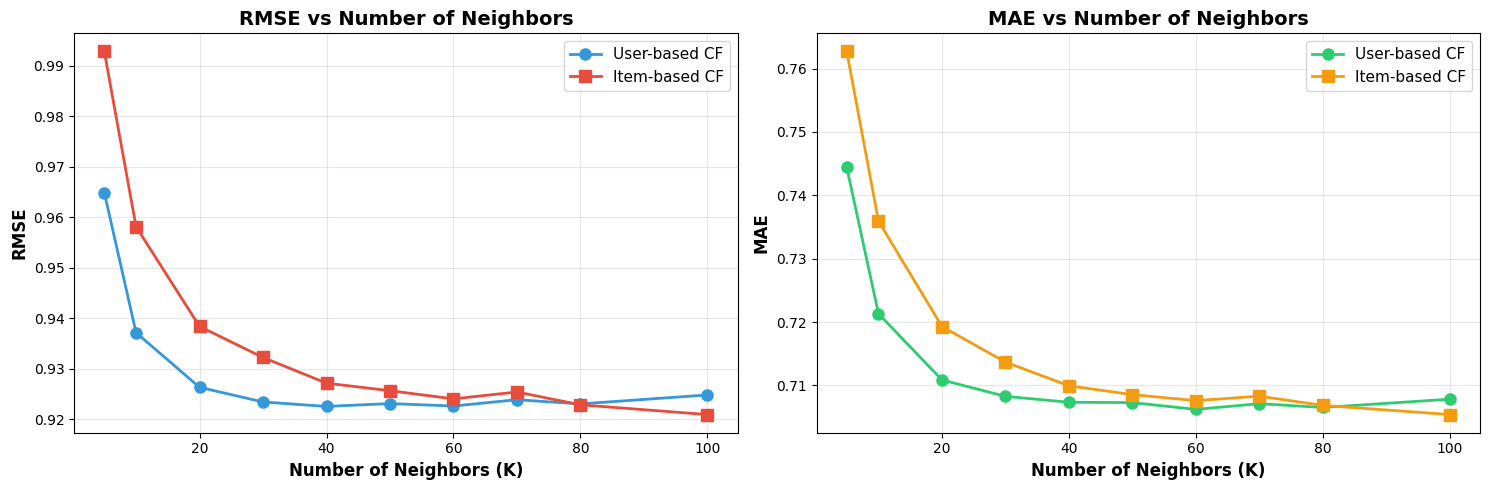


BEST NUMBER OF NEIGHBORS (K):

Based on RMSE:
  User-based CF: K = 40 (RMSE = 0.9226)
  Item-based CF: K = 100 (RMSE = 0.9210)

Based on MAE:
  User-based CF: K = 60 (MAE = 0.7062)
  Item-based CF: K = 100 (MAE = 0.7054)

Is the best K the same for User and Item-based CF (RMSE)? False
User-based CF works best with K = 40
Item-based CF works best with K = 100

Visualization saved as 'neighbors_impact.png'


In [6]:
# ============================================================================
# BLOCK 6: Impact of Number of Neighbors (Question f, g)
# ============================================================================

print("\n" + "=" * 80)
print("EXAMINING IMPACT OF NUMBER OF NEIGHBORS")
print("=" * 80)

# Define range of K values to test
k_values = [5, 10, 20, 30, 40, 50, 60, 70, 80, 100]

# Store results
user_k_results = {'RMSE': [], 'MAE': []}
item_k_results = {'RMSE': [], 'MAE': []}

# Test User-based CF with different K values
print("\nUser-based Collaborative Filtering:")
print("-" * 80)

for k in k_values:
    print(f"Testing with K = {k}...")

    sim_options = {
        'name': 'cosine',
        'user_based': True
    }

    algo = KNNWithMeans(k=k, sim_options=sim_options)
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

    user_k_results['RMSE'].append(results['test_rmse'].mean())
    user_k_results['MAE'].append(results['test_mae'].mean())

    print(f"  RMSE: {results['test_rmse'].mean():.4f}, MAE: {results['test_mae'].mean():.4f}")

# Test Item-based CF with different K values
print("\n" + "-" * 80)
print("Item-based Collaborative Filtering:")
print("-" * 80)

for k in k_values:
    print(f"Testing with K = {k}...")

    sim_options = {
        'name': 'cosine',
        'user_based': False
    }

    algo = KNNWithMeans(k=k, sim_options=sim_options)
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

    item_k_results['RMSE'].append(results['test_rmse'].mean())
    item_k_results['MAE'].append(results['test_mae'].mean())

    print(f"  RMSE: {results['test_rmse'].mean():.4f}, MAE: {results['test_mae'].mean():.4f}")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# RMSE vs K
axes[0].plot(k_values, user_k_results['RMSE'], marker='o', linewidth=2,
             markersize=8, label='User-based CF', color='#3498db')
axes[0].plot(k_values, item_k_results['RMSE'], marker='s', linewidth=2,
             markersize=8, label='Item-based CF', color='#e74c3c')
axes[0].set_xlabel('Number of Neighbors (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('RMSE vs Number of Neighbors', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11, loc='best')
axes[0].grid(True, alpha=0.3)

# MAE vs K
axes[1].plot(k_values, user_k_results['MAE'], marker='o', linewidth=2,
             markersize=8, label='User-based CF', color='#2ecc71')
axes[1].plot(k_values, item_k_results['MAE'], marker='s', linewidth=2,
             markersize=8, label='Item-based CF', color='#f39c12')
axes[1].set_xlabel('Number of Neighbors (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('MAE vs Number of Neighbors', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11, loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('neighbors_impact.png', dpi=300, bbox_inches='tight')
plt.show()

# Find best K values
best_k_user_rmse = k_values[np.argmin(user_k_results['RMSE'])]
best_k_item_rmse = k_values[np.argmin(item_k_results['RMSE'])]
best_k_user_mae = k_values[np.argmin(user_k_results['MAE'])]
best_k_item_mae = k_values[np.argmin(item_k_results['MAE'])]

print("\n" + "=" * 80)
print("BEST NUMBER OF NEIGHBORS (K):")
print("=" * 80)

print("\nBased on RMSE:")
print(f"  User-based CF: K = {best_k_user_rmse} "
      f"(RMSE = {min(user_k_results['RMSE']):.4f})")
print(f"  Item-based CF: K = {best_k_item_rmse} "
      f"(RMSE = {min(item_k_results['RMSE']):.4f})")

print("\nBased on MAE:")
print(f"  User-based CF: K = {best_k_user_mae} "
      f"(MAE = {min(user_k_results['MAE']):.4f})")
print(f"  Item-based CF: K = {best_k_item_mae} "
      f"(MAE = {min(item_k_results['MAE']):.4f})")

print("\n" + "=" * 80)
print(f"Is the best K the same for User and Item-based CF (RMSE)? "
      f"{best_k_user_rmse == best_k_item_rmse}")
if best_k_user_rmse != best_k_item_rmse:
    print(f"User-based CF works best with K = {best_k_user_rmse}")
    print(f"Item-based CF works best with K = {best_k_item_rmse}")
else:
    print(f"Both methods work best with K = {best_k_user_rmse}")

print("\nVisualization saved as 'neighbors_impact.png'")

#### g) Identify the best number of neighbor (denoted by K) for User/Item based collaborative filtering in terms of RMSE. Is the best K of User based collaborative filtering the same with the best K of Item based collaborative filtering? (10 points)

* User-based CF works best with K = 40
* Item-based CF works best with K = 100

### SUMMARY

In [7]:
# ============================================================================
# BLOCK 7: Final Summary and Results
# ============================================================================

print("\n" + "=" * 80)
print("FINAL SUMMARY OF ALL EXPERIMENTS")
print("=" * 80)

# Create comprehensive results summary
summary_data = {
    'Experiment': [
        'PMF (SVD)',
        'User-based CF (cosine, K=40)',
        'Item-based CF (cosine, K=40)',
        f'User-based CF (best sim: {min(user_sim_results["RMSE"], key=user_sim_results["RMSE"].get)})',
        f'Item-based CF (best sim: {min(item_sim_results["RMSE"], key=item_sim_results["RMSE"].get)})',
        f'User-based CF (best K: {best_k_user_rmse})',
        f'Item-based CF (best K: {best_k_item_rmse})'
    ],
    'RMSE': [
        results_dict['PMF']['RMSE'],
        results_dict['User-based CF']['RMSE'],
        results_dict['Item-based CF']['RMSE'],
        min(user_sim_results['RMSE'].values()),
        min(item_sim_results['RMSE'].values()),
        min(user_k_results['RMSE']),
        min(item_k_results['RMSE'])
    ],
    'MAE': [
        results_dict['PMF']['MAE'],
        results_dict['User-based CF']['MAE'],
        results_dict['Item-based CF']['MAE'],
        min(user_sim_results['MAE'].values()),
        min(item_sim_results['MAE'].values()),
        min(user_k_results['MAE']),
        min(item_k_results['MAE'])
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\nComprehensive Results Table:")
print(summary_df.to_string(index=False))

# Overall best model
overall_best_rmse_idx = summary_df['RMSE'].idxmin()
overall_best_mae_idx = summary_df['MAE'].idxmin()

print("\n" + "=" * 80)
print("OVERALL BEST CONFIGURATIONS:")
print("=" * 80)
print(f"\nBest by RMSE: {summary_df.loc[overall_best_rmse_idx, 'Experiment']}")
print(f"  RMSE = {summary_df.loc[overall_best_rmse_idx, 'RMSE']:.4f}")
print(f"  MAE = {summary_df.loc[overall_best_rmse_idx, 'MAE']:.4f}")

print(f"\nBest by MAE: {summary_df.loc[overall_best_mae_idx, 'Experiment']}")
print(f"  RMSE = {summary_df.loc[overall_best_mae_idx, 'RMSE']:.4f}")
print(f"  MAE = {summary_df.loc[overall_best_mae_idx, 'MAE']:.4f}")

# Save results to CSV
summary_df.to_csv('recommender_results_summary.csv', index=False)
print("\n" + "=" * 80)
print("Results saved to 'recommender_results_summary.csv'")
print("=" * 80)

print("\n" + "=" * 80)
print("ANSWERS TO ALL QUESTIONS:")
print("=" * 80)

print("\nQuestion (c): Average MAE and RMSE with 5-fold CV")
print(f"  PMF: RMSE={results_dict['PMF']['RMSE']:.4f}, MAE={results_dict['PMF']['MAE']:.4f}")
print(f"  User-based CF: RMSE={results_dict['User-based CF']['RMSE']:.4f}, MAE={results_dict['User-based CF']['MAE']:.4f}")
print(f"  Item-based CF: RMSE={results_dict['Item-based CF']['RMSE']:.4f}, MAE={results_dict['Item-based CF']['MAE']:.4f}")

print("\nQuestion (d): Best ML model")
print(f"  Best model: {best_rmse}")
print(f"  This model has the lowest RMSE and MAE values")

print("\nQuestion (e): Impact of similarity metrics")
print(f"  User-based CF - Best similarity: {min(user_sim_results['RMSE'], key=user_sim_results['RMSE'].get)}")
print(f"  Item-based CF - Best similarity: {min(item_sim_results['RMSE'], key=item_sim_results['RMSE'].get)}")
print(f"  Impact consistent? {user_best_rmse == item_best_rmse}")

print("\nQuestion (f & g): Best number of neighbors")
print(f"  User-based CF - Best K: {best_k_user_rmse} (RMSE: {min(user_k_results['RMSE']):.4f})")
print(f"  Item-based CF - Best K: {best_k_item_rmse} (RMSE: {min(item_k_results['RMSE']):.4f})")
print(f"  Same best K? {best_k_user_rmse == best_k_item_rmse}")

print("\n" + "=" * 80)
print("ALL EXPERIMENTS COMPLETED SUCCESSFULLY")
print("=" * 80)
print("\nGenerated Files:")
print("  1. algorithm_comparison.png")
print("  2. similarity_metrics_impact.png")
print("  3. neighbors_impact.png")
print("  4. recommender_results_summary.csv")
print("=" * 80)


FINAL SUMMARY OF ALL EXPERIMENTS

Comprehensive Results Table:
                   Experiment     RMSE      MAE
                    PMF (SVD) 0.896321 0.690015
 User-based CF (cosine, K=40) 0.924375 0.708861
 Item-based CF (cosine, K=40) 0.926294 0.709001
User-based CF (best sim: msd) 0.919635 0.703489
Item-based CF (best sim: msd) 0.916960 0.701385
   User-based CF (best K: 40) 0.922576 0.706207
  Item-based CF (best K: 100) 0.920962 0.705392

OVERALL BEST CONFIGURATIONS:

Best by RMSE: PMF (SVD)
  RMSE = 0.8963
  MAE = 0.6900

Best by MAE: PMF (SVD)
  RMSE = 0.8963
  MAE = 0.6900

Results saved to 'recommender_results_summary.csv'

ANSWERS TO ALL QUESTIONS:

Question (c): Average MAE and RMSE with 5-fold CV
  PMF: RMSE=0.8963, MAE=0.6900
  User-based CF: RMSE=0.9244, MAE=0.7089
  Item-based CF: RMSE=0.9263, MAE=0.7090

Question (d): Best ML model
  Best model: PMF
  This model has the lowest RMSE and MAE values

Question (e): Impact of similarity metrics
  User-based CF - Best simila